# Data pre-processing

In [1]:
!pip install h5py
!pip install tensorflow

In [2]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
from scipy.stats.stats import mode
import seaborn as sns
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

# Classifier models
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report


# Statistic libraries
from scipy.optimize import fmin, minimize_scalar
from scipy import stats

# Image processing
from functools import partial
import pywt
from skimage import feature
from skimage.filters import sobel
import skimage as sk
import skimage.filters as fl
import skimage.restoration as rs

# OpenCV libraries
import cv2 as cv
from google.colab.patches import cv2_imshow

# Importing Keras library from Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import concatenate
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import load_model
from os import makedirs

## Download the `app.py` file from the repo and upload it in the local environement of the notebook

In [3]:
from app import EvaluateAndReport, add_features, plot_features, to_RGB, get_distrib, DeepLearningExplore

## Add OpenCV functions

Retrieving the contour of the images

In [4]:
def add_sobel_features(datasobel, label, data) :
  #Find the contour pixels by taking out the max 75 elements
  datasobel['contourpixel_b'+str(label)] = [np.array(matx)[np.argpartition(np.array(matx), -75)[-75:]] for matx in datasobel['band_'+str(label)]]

  data['max_of_contour_b'+str(label)] = [np.max(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['min_of_contour_b'+str(label)] = [np.min(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['median_of_contour_b'+str(label)] = [np.median(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['mean_of_contour_b'+str(label)] = [np.mean(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['argmax_of_contour_b'+str(label)] = [np.argmax(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['argmin_of_contour_b'+str(label)] = [np.argmin(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['variance_of_contour_b'+str(label)] = [np.var(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]

  return data

Using `OpenCV` to access other features of the contour such as the **area**, the **perimeter**...

In [5]:
def contour(matx):
  # denoising the image
  image = rs.denoise_tv_chambolle(rs.denoise_bilateral(np.array(matx), sigma_spatial = 1), weight = 0.1)
  image = (image-np.amin(image))/(np.amax(image)-np.amin(image))

  # transferring to 8 bit format
  image_8bit = np.array(np.uint8(image * 255))

  threshold_level = 155 # Set as we need...
  ret, binarized = cv.threshold(image_8bit, threshold_level, 255, cv.THRESH_BINARY)

  contours, _ = cv.findContours(binarized, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  cv.drawContours(image, contours,-1,(0,255,0), 1)
  plt.imshow(image)
  cnt = contours[0]
  # deleting unsignificant contours
  if cnt.size<10:
    cnt=contours[len(contours)-1]


  #Surace area of the contour
  area = cv.contourArea(cnt)

  #Perimeter of the contour
  perimeter = cv.arcLength(cnt,True)

  #A/P ratio
  AP_Ratio=area/perimeter

  #Ellipse
  if cnt.size>=10:
    ellipse = (x, y), (MA, ma), angle = cv.fitEllipse(cnt)
    A = np.pi * MA * ma/4
    ellipse_ratio=area/A
  else: 
    ellipse_ratio = "not_available"

  
  return area, perimeter, AP_Ratio, ellipse_ratio

In [6]:
def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

In [7]:
def MatrixtoArray(data, label) :
  data['band_'+str(label)] = [np.array(matx).ravel() for matx in data['band_'+str(label)]]

In [8]:
#Denoise all images and draw the contour
def denoiseimg(x):
  y = np.array(x).reshape(75,75)
  y = (y - y.min())/(y.max()-y.min())
  y = rs.denoise_tv_chambolle(rs.denoise_bilateral(y.reshape(75,75), sigma_spatial = 1), weight = 0.1)
  y = y.ravel()
  return y

## Data processing

In [9]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

# returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# Train/test split
df_full = df_raw.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df_full.index)

# Changing inc_angle from object to float64
df_full.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df_full['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df_full[df_full.inc_angle.isna()] # 133 NaN

# Adding more features to the initial dataset
def add_features(data, label) :
  data['max_b'+str(label)] = [np.max(np.array(matx)) for matx in data['band_'+str(label)]]
  data['min_b'+str(label)] = [np.min(np.array(matx)) for matx in data['band_'+str(label)]]
  data['delta_b'+str(label)] = [(np.max(np.array(matx))-np.min(np.array(matx))) for matx in data['band_'+str(label)]]
  data['median_b'+str(label)] = [np.median(np.array(matx)) for matx in data['band_'+str(label)]]
  data['mean_b'+str(label)] = [np.mean(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmax_b'+str(label)] = [np.argmax(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmin_b'+str(label)] = [np.argmin(np.array(matx)) for matx in data['band_'+str(label)]]
  data['band_'+str(label)] = [np.array(matx).reshape(75,75) for matx in data['band_'+str(label)]]
  return data
  
df_full = add_features(df_full,1)
df_full = add_features(df_full,2)

df_full['delta_max'] = df_full[['delta_b1','delta_b2']].apply(np.max,axis=1)

# Creating the two weighted bands
df_full["band_2ab"] = (2*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(1*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3*np.array(df_full["delta_max"]))
df_full["band_a2b"] = (1*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(2*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3*np.array(df_full["delta_max"]))

# Creating the final dataframe
df = pd.DataFrame()
df['band_1'] = df_full["band_2ab"]
df['band_2'] = df_full["band_a2b"]
df['is_iceberg'] = df_full['is_iceberg']

Mounted at /content/drive


In [10]:
# Visualising info
df.head()

,band_1,band_2,is_iceberg
530,"[[0.25427745278591074, 0.3460855742596355, 0.3...","[[0.26592376580780336, 0.3247187761665669, 0.3...",1
1140,"[[0.2707324495406702, 0.30480775175573926, 0.3...","[[0.24267567798256903, 0.30020406674866845, 0....",1
168,"[[0.38617910781788845, 0.43987529136428566, 0....","[[0.41462617396260637, 0.44598581086903305, 0....",0
135,"[[0.37422338765966945, 0.41115484466890545, 0....","[[0.39863373809855784, 0.38507994752080904, 0....",1
438,"[[0.29135156222418807, 0.22909160205562515, 0....","[[0.28848498437832754, 0.20767722540976924, 0....",0


Add OpenCV features

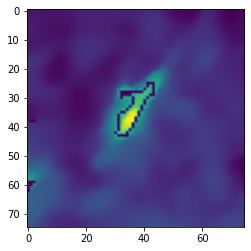

In [11]:
df=apply_and_concat(df, 'band_1', contour, ['area1', 'perimeter1', 'AP_Ratio1', 'ellipse_ratio1'])
df=apply_and_concat(df, 'band_2', contour, ['area2', 'perimeter2', 'AP_Ratio2', 'ellipse_ratio2'])

Denoising and then retrieving statistics such as the max, min, variance...

In [12]:
df["band_1_denoised"]=df["band_1"].apply(denoiseimg)
df["band_2_denoised"]=df["band_2"].apply(denoiseimg)
df.head()

,band_1,band_2,is_iceberg,area1,perimeter1,AP_Ratio1,ellipse_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,band_1_denoised,band_2_denoised
530,"[[0.25427745278591074, 0.3460855742596355, 0.3...","[[0.26592376580780336, 0.3247187761665669, 0.3...",1,16.5,17.071068,0.966548,0.849968,19.0,19.313708,0.983757,0.799069,"[0.3027018387163264, 0.3086967096202151, 0.313...","[0.3171222476604406, 0.31978013138977623, 0.32..."
1140,"[[0.2707324495406702, 0.30480775175573926, 0.3...","[[0.24267567798256903, 0.30020406674866845, 0....",1,18.5,17.071068,1.083705,0.851587,24.0,19.656854,1.220948,0.826592,"[0.39311979434510835, 0.3937791850604914, 0.39...","[0.4641757261454722, 0.472544322632997, 0.4756..."
168,"[[0.38617910781788845, 0.43987529136428566, 0....","[[0.41462617396260637, 0.44598581086903305, 0....",0,12.0,13.656854,0.878680,0.821471,10.0,12.828427,0.779519,0.693706,"[0.31792838485258484, 0.31776602276183746, 0.3...","[0.356177794111638, 0.35623580952320666, 0.356..."
135,"[[0.37422338765966945, 0.41115484466890545, 0....","[[0.39863373809855784, 0.38507994752080904, 0....",1,40.0,28.485281,1.404234,0.686139,97.5,43.213203,2.256255,0.798863,"[0.4951023152764658, 0.49267969309129556, 0.48...","[0.45468968944246146, 0.4505054401238178, 0.44..."
438,"[[0.29135156222418807, 0.22909160205562515, 0....","[[0.28848498437832754, 0.20767722540976924, 0....",0,57.0,36.142135,1.577107,0.836376,60.0,36.970562,1.622913,0.768132,"[0.1543941904441097, 0.15440201585937474, 0.15...","[0.21960511546075726, 0.21964319940195198, 0.2..."


In [13]:
df_image = pd.DataFrame(columns = ['band_1', 'band_2'])
df_image['band_1'] = df["band_1_denoised"]
df_image['band_2'] = df["band_2_denoised"]
df_image = add_features(df_image,1)
df_image = add_features(df_image,2)

In [14]:
df_image = df_image.drop(['band_1', 'band_2'], axis=1)
df = df.drop(['band_1_denoised', 'band_2_denoised'], axis=1)
df = df.join(df_image)

In [15]:
df.head()

,band_1,band_2,is_iceberg,area1,perimeter1,AP_Ratio1,ellipse_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,max_b1,min_b1,delta_b1,median_b1,mean_b1,argmax_b1,argmin_b1,max_b2,min_b2,delta_b2,median_b2,mean_b2,argmax_b2,argmin_b2
530,"[[0.25427745278591074, 0.3460855742596355, 0.3...","[[0.26592376580780336, 0.3247187761665669, 0.3...",1,16.5,17.071068,0.966548,0.849968,19.0,19.313708,0.983757,0.799069,0.714644,0.177522,0.537122,0.343956,0.347891,2668,5624,0.729671,0.173227,0.556445,0.357714,0.360774,2668,5624
1140,"[[0.2707324495406702, 0.30480775175573926, 0.3...","[[0.24267567798256903, 0.30020406674866845, 0....",1,18.5,17.071068,1.083705,0.851587,24.0,19.656854,1.220948,0.826592,0.739754,0.196455,0.543299,0.355573,0.351798,2813,5593,0.714887,0.238573,0.476314,0.435984,0.435931,2813,5606
168,"[[0.38617910781788845, 0.43987529136428566, 0....","[[0.41462617396260637, 0.44598581086903305, 0....",0,12.0,13.656854,0.878680,0.821471,10.0,12.828427,0.779519,0.693706,0.771656,0.234640,0.537016,0.307987,0.308551,3124,2100,0.751905,0.246474,0.505431,0.363351,0.364131,3198,2100
135,"[[0.37422338765966945, 0.41115484466890545, 0....","[[0.39863373809855784, 0.38507994752080904, 0....",1,40.0,28.485281,1.404234,0.686139,97.5,43.213203,2.256255,0.798863,0.814089,0.299695,0.514394,0.458363,0.460589,2585,5512,0.771002,0.134349,0.636653,0.452829,0.455427,2585,5624
438,"[[0.29135156222418807, 0.22909160205562515, 0....","[[0.28848498437832754, 0.20767722540976924, 0....",0,57.0,36.142135,1.577107,0.836376,60.0,36.970562,1.622913,0.768132,0.773075,0.124915,0.648160,0.193758,0.206554,3186,5607,0.762194,0.207713,0.554481,0.247818,0.260685,3113,5607


## Add Sobel contour features

In [16]:
df_sobel = pd.DataFrame(columns=['band_1','band_2'])

def sobelimg(x):
  y = np.array(x).reshape(75,75)
  y = sobel(y)
  y = y.ravel()
  return y

df_sobel["band_1"]=df["band_1"].apply(sobelimg)
df_sobel["band_2"]=df["band_2"].apply(sobelimg)


df = add_sobel_features(df_sobel,1,df)
df = add_sobel_features(df_sobel,2,df)
df.head()

,band_1,band_2,is_iceberg,area1,perimeter1,AP_Ratio1,ellipse_ratio1,area2,perimeter2,AP_Ratio2,ellipse_ratio2,max_b1,min_b1,delta_b1,median_b1,mean_b1,argmax_b1,argmin_b1,max_b2,min_b2,delta_b2,median_b2,mean_b2,argmax_b2,argmin_b2,max_of_contour_b1,min_of_contour_b1,median_of_contour_b1,mean_of_contour_b1,argmax_of_contour_b1,argmin_of_contour_b1,variance_of_contour_b1,max_of_contour_b2,min_of_contour_b2,median_of_contour_b2,mean_of_contour_b2,argmax_of_contour_b2,argmin_of_contour_b2,variance_of_contour_b2
530,"[[0.25427745278591074, 0.3460855742596355, 0.3...","[[0.26592376580780336, 0.3247187761665669, 0.3...",1,16.5,17.071068,0.966548,0.849968,19.0,19.313708,0.983757,0.799069,0.714644,0.177522,0.537122,0.343956,0.347891,2668,5624,0.729671,0.173227,0.556445,0.357714,0.360774,2668,5624,0.314455,0.132965,0.152969,0.168900,69,0,0.001701,0.279383,0.130361,0.140275,0.153616,35,0,0.001008
1140,"[[0.2707324495406702, 0.30480775175573926, 0.3...","[[0.24267567798256903, 0.30020406674866845, 0....",1,18.5,17.071068,1.083705,0.851587,24.0,19.656854,1.220948,0.826592,0.739754,0.196455,0.543299,0.355573,0.351798,2813,5593,0.714887,0.238573,0.476314,0.435984,0.435931,2813,5606,0.315000,0.133012,0.159822,0.175077,43,0,0.002099,0.212382,0.117964,0.130520,0.138317,30,0,0.000451
168,"[[0.38617910781788845, 0.43987529136428566, 0....","[[0.41462617396260637, 0.44598581086903305, 0....",0,12.0,13.656854,0.878680,0.821471,10.0,12.828427,0.779519,0.693706,0.771656,0.234640,0.537016,0.307987,0.308551,3124,2100,0.751905,0.246474,0.505431,0.363351,0.364131,3198,2100,0.304163,0.125721,0.147792,0.171346,66,0,0.002575,0.267579,0.120319,0.138508,0.153088,42,0,0.001261
135,"[[0.37422338765966945, 0.41115484466890545, 0....","[[0.39863373809855784, 0.38507994752080904, 0....",1,40.0,28.485281,1.404234,0.686139,97.5,43.213203,2.256255,0.798863,0.814089,0.299695,0.514394,0.458363,0.460589,2585,5512,0.771002,0.134349,0.636653,0.452829,0.455427,2585,5624,0.252451,0.146138,0.162007,0.171719,70,0,0.000734,0.207228,0.147487,0.159356,0.164316,65,0,0.000240
438,"[[0.29135156222418807, 0.22909160205562515, 0....","[[0.28848498437832754, 0.20767722540976924, 0....",0,57.0,36.142135,1.577107,0.836376,60.0,36.970562,1.622913,0.768132,0.773075,0.124915,0.648160,0.193758,0.206554,3186,5607,0.762194,0.207713,0.554481,0.247818,0.260685,3113,5607,0.348164,0.167127,0.213435,0.221471,63,0,0.001727,0.347137,0.160798,0.197127,0.210884,66,0,0.001598


In [17]:
df.describe()

,is_iceberg,area1,perimeter1,AP_Ratio1,area2,perimeter2,AP_Ratio2,max_b1,min_b1,delta_b1,median_b1,mean_b1,argmax_b1,argmin_b1,max_b2,min_b2,delta_b2,median_b2,mean_b2,argmax_b2,argmin_b2,max_of_contour_b1,min_of_contour_b1,median_of_contour_b1,mean_of_contour_b1,argmax_of_contour_b1,argmin_of_contour_b1,variance_of_contour_b1,max_of_contour_b2,min_of_contour_b2,median_of_contour_b2,mean_of_contour_b2,argmax_of_contour_b2,argmin_of_contour_b2,variance_of_contour_b2
count,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.0,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.000000,1283.0,1283.000000
mean,0.475448,65.931021,33.263930,1.484654,104.473500,35.877645,1.628390,0.764224,0.184209,0.580015,0.296216,0.305489,2831.836321,4314.064692,0.758496,0.197393,0.561103,0.324045,0.332550,2827.148870,4348.565082,0.316922,0.149195,0.180567,0.193033,52.671863,0.0,0.001796,0.288019,0.142181,0.168995,0.179567,52.448948,0.0,0.001364
std,0.499592,200.782605,23.447551,0.807447,483.497856,35.568188,1.543747,0.035808,0.064160,0.080613,0.079694,0.074346,376.578147,1915.867448,0.039305,0.067584,0.086221,0.098763,0.093166,447.313873,1884.435557,0.045000,0.021840,0.026092,0.023473,16.316747,0.0,0.001208,0.054132,0.023284,0.029591,0.028949,16.520667,0.0,0.001060
min,0.000000,1.500000,7.414214,0.202314,1.000000,4.828427,0.207107,0.622906,0.039329,0.256316,0.128057,0.161972,0.000000,0.000000,0.603228,0.043604,0.196368,0.129787,0.160699,2.000000,0.000000,0.203571,0.098764,0.116751,0.133621,1.000000,0.0,0.000235,0.146799,0.078968,0.096390,0.102128,3.000000,0.0,0.000101
25%,0.000000,17.500000,18.242641,0.958047,19.500000,19.071068,0.977681,0.741612,0.141254,0.528880,0.233885,0.244468,2662.000000,2999.500000,0.733712,0.152611,0.503303,0.246671,0.258529,2661.000000,3300.000000,0.283358,0.133624,0.162270,0.176843,42.000000,0.0,0.000919,0.247214,0.125354,0.147415,0.158926,41.000000,0.0,0.000591
50%,0.000000,39.000000,28.142135,1.343146,42.000000,29.556349,1.411420,0.764490,0.184336,0.579817,0.293090,0.299711,2811.000000,5550.000000,0.759951,0.196447,0.562051,0.317682,0.323106,2811.000000,5550.000000,0.314002,0.147966,0.177721,0.189517,56.000000,0.0,0.001478,0.285673,0.140848,0.166032,0.178112,56.000000,0.0,0.001075
75%,1.000000,77.500000,43.041630,1.831352,82.000000,44.284271,1.887056,0.787809,0.224829,0.635057,0.347638,0.353100,2962.000000,5603.500000,0.783869,0.238058,0.618406,0.382510,0.387288,2962.000000,5602.000000,0.348065,0.163316,0.196317,0.206319,66.000000,0.0,0.002283,0.323924,0.157896,0.187100,0.198424,66.000000,0.0,0.001856
max,1.000000,4956.000000,446.308655,14.475672,5473.000000,677.788884,18.511325,0.872848,0.495393,0.814659,0.576698,0.578590,5607.000000,5624.000000,0.884864,0.512786,0.805595,0.647878,0.647815,5611.000000,5624.000000,0.469359,0.242114,0.291187,0.295798,74.000000,0.0,0.008834,0.461950,0.251833,0.303935,0.309564,74.000000,0.0,0.007258


Remove useless features

In [18]:
df = df.drop(['argmin_of_contour_b1', 'argmin_of_contour_b2'], axis=1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 530 to 546
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   band_1                  1283 non-null   object 
 1   band_2                  1283 non-null   object 
 2   is_iceberg              1283 non-null   int64  
 3   area1                   1283 non-null   float64
 4   perimeter1              1283 non-null   float64
 5   AP_Ratio1               1283 non-null   float64
 6   ellipse_ratio1          1283 non-null   object 
 7   area2                   1283 non-null   float64
 8   perimeter2              1283 non-null   float64
 9   AP_Ratio2               1283 non-null   float64
 10  ellipse_ratio2          1283 non-null   object 
 11  max_b1                  1283 non-null   float64
 12  min_b1                  1283 non-null   float64
 13  delta_b1                1283 non-null   float64
 14  median_b1               1283 non-null  

There are 13 images where there are fewer than 4 points on the contour therefore not possible to draw an ellipse

In [20]:
df.drop(df.loc[df["ellipse_ratio1"]=='not_available'].index, inplace=True)
df.drop(df.loc[df["ellipse_ratio2"]=='not_available'].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271 entries, 530 to 546
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   band_1                  1271 non-null   object 
 1   band_2                  1271 non-null   object 
 2   is_iceberg              1271 non-null   int64  
 3   area1                   1271 non-null   float64
 4   perimeter1              1271 non-null   float64
 5   AP_Ratio1               1271 non-null   float64
 6   ellipse_ratio1          1271 non-null   object 
 7   area2                   1271 non-null   float64
 8   perimeter2              1271 non-null   float64
 9   AP_Ratio2               1271 non-null   float64
 10  ellipse_ratio2          1271 non-null   object 
 11  max_b1                  1271 non-null   float64
 12  min_b1                  1271 non-null   float64
 13  delta_b1                1271 non-null   float64
 14  median_b1               1271 non-null  

# Train/test split

In [21]:
# Train/test split for the whole project as we don't have a test dataset
df_train = df.sample(frac = 0.8, random_state = 42)
df_test = df.drop(df_train.index)

## Preparing CNN input

In [22]:
X_b1=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df_train["band_1"]]
    )

X_b2=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df_train["band_2"]]
    )

train_cnn = np.concatenate([X_b1[:, :, :, np.newaxis], X_b2[:, :, :, np.newaxis]], axis=-1)
target_tf=df_train['is_iceberg']

Test data pre-processing to match TF inputs types

In [23]:
X_b1_test=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df_test["band_1"]]
    )

X_b2_test=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df_test["band_2"]]
    )

test_cnn = np.concatenate([X_b1_test[:, :, :, np.newaxis], X_b2_test[:, :, :, np.newaxis]], axis=-1)
test_target_tf=df_test['is_iceberg']

## Preparing MLP input

In [24]:
X_train_stats = df_train.loc[:,['max_b1','median_b1','mean_b1','max_b2','median_b2','mean_b2',
           'max_of_contour_b1','min_of_contour_b1','median_of_contour_b1','mean_of_contour_b1','variance_of_contour_b1',
           'max_of_contour_b2','min_of_contour_b2','median_of_contour_b2','mean_of_contour_b2','variance_of_contour_b2',
           'area1','perimeter1','AP_Ratio1','ellipse_ratio1',
           'area2','perimeter2','AP_Ratio2','ellipse_ratio2']]

X_test_stats = df_test.loc[:,['max_b1','median_b1','mean_b1','max_b2','median_b2','mean_b2',
           'max_of_contour_b1','min_of_contour_b1','median_of_contour_b1','mean_of_contour_b1','variance_of_contour_b1',
           'max_of_contour_b2','min_of_contour_b2','median_of_contour_b2','mean_of_contour_b2','variance_of_contour_b2',
           'area1','perimeter1','AP_Ratio1','ellipse_ratio1',
           'area2','perimeter2','AP_Ratio2','ellipse_ratio2']]

# Defining the multi-inputs models

## Creating our MLP Network

In [71]:
def mlp_model(dim):
  # define the MLP architecture for numerical data
  model = Sequential()
  model.add(Dense(24, input_dim=dim, activation="relu"))
  model.add(Dense(16, activation="relu"))

  # return the model
  return model

## Creating our CNN network (*Model 5C3D inspired*)

In [72]:
def cnn_model(width, height, depth, filters=(8, 16, 32, 64)):
  # initialize the input shape and channel dimension
  inputShape = (height, width, depth)
  chanDim = -1
  # define the model input
  inputs = Input(shape=inputShape)

  ########################
  ## CONVOLUTIONAL BASE ##
  ########################

  # loop over the number of filters
  # 5 convolution blocks
  for (i, f) in enumerate(filters):
    if i == 0:
      x = inputs
    x = Conv2D(f, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

  ########################
  ##    DENSE HEAD      ##
  ########################

  # flatten the volume
  x = Flatten()(x)

  # 3 dense blocks
  x = Dense(32)(x)
  x = Activation("relu")(x)
  x = Dropout(0.1)(x)
  # coming out of the MLP
  x = Dense(16)(x)
  x = Activation("relu")(x)
  # check to see if the regression node should be added

  # construct the CNN
  model = Model(inputs, x)


  # return the CNN
  return model

## Concatenating the MLP and CNN models

In [73]:
# create the MLP and CNN models
mlp = mlp_model(X_train_stats.shape[1])
cnn = cnn_model(75, 75, 2)

combinedInput = concatenate([mlp.output, cnn.output])

# our final FC layer head will have two dense layers, the final one
# being our classification head
x = Dense(16, activation="relu")(combinedInput)
x = Dense(1, activation="sigmoid")(x)

# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value : the probability
# for the image being an iceberg
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

# Training the hybrid model

In [75]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
    )

In [76]:
checkpointer = ModelCheckpoint(
      filepath="best_hybrid_model.h5", 
      monitor = 'val_binary_accuracy',
      verbose=1, 
      save_best_only=True
    )

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [77]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 75, 75, 2)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 75, 75, 8)    152         ['input_8[0][0]']                
                                                                                                  
 activation_48 (Activation)     (None, 75, 75, 8)    0           ['conv2d_28[0][0]']              
                                                                                                  
 max_pooling2d_28 (MaxPooling2D  (None, 37, 37, 8)   0           ['activation_48[0][0]']          
 )                                                                                         

In [78]:
tf.config.experimental_run_functions_eagerly(True)

X_train_stats= np.asarray( X_train_stats).astype('float32')
X_tesy_stats= np.asarray( X_test_stats).astype('float32')

X_train_stats = tf.convert_to_tensor(X_train_stats, dtype=tf.float32)
X_test_stats = tf.convert_to_tensor(X_test_stats, dtype=tf.float32)

history = model.fit(
	x=[X_train_stats, train_cnn], y=target_tf,
	validation_data=([X_test_stats, test_cnn], test_target_tf),
	epochs=80, batch_size=19, callbacks=[checkpointer, early_stopping])

Epoch 1/80
 1/54 [..............................] - ETA: 4s - loss: 0.9677 - binary_accuracy: 0.6842

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



54/54 [==============================] - ETA: 0s - loss: 1.4902 - binary_accuracy: 0.5900
Epoch 00001: val_binary_accuracy improved from -inf to 0.55118, saving model to best_hybrid_model.h5
54/54 [==============================] - 3s 53ms/step - loss: 1.4902 - binary_accuracy: 0.5900 - val_loss: 0.7021 - val_binary_accuracy: 0.5512
Epoch 2/80
53/54 [============================>.] - ETA: 0s - loss: 0.8283 - binary_accuracy: 0.5909
Epoch 00002: val_binary_accuracy did not improve from 0.55118
54/54 [==============================] - 3s 50ms/step - loss: 0.8273 - binary_accuracy: 0.5900 - val_loss: 0.6816 - val_binary_accuracy: 0.5394
Epoch 3/80
54/54 [==============================] - ETA: 0s - loss: 0.7980 - binary_accuracy: 0.6116
Epoch 00003: val_binary_accuracy improved from 0.55118 to 0.62598, saving model to best_hybrid_model.h5
54/54 [==============================] - 3s 51ms/step - loss: 0.7980 - binary_accuracy: 0.6116 - val_loss: 0.6443 - val_binary_accuracy: 0.6260
Epoch 4/8

Minimum Validation Loss: 0.1948
Maximum Validation Accuracy: 0.9213


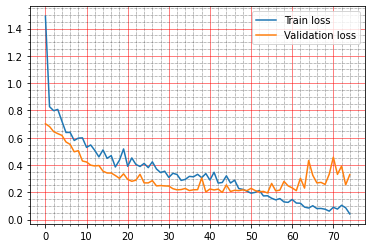

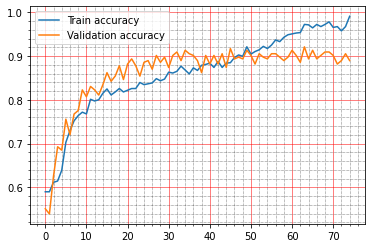

In [79]:
fig, ax = plt.subplots()
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax)
# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)
# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()
# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.legend(["Train loss", "Validation loss"])
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

fig1, ax1 = plt.subplots()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(ax=ax1)
ax1.set_axisbelow(True)
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax1.legend(["Train accuracy", "Validation accuracy"])
print(("Maximum Validation Accuracy: {:0.4f}").format(history_df['val_binary_accuracy'].max()))

# Horizontal vote for the hybrid model

In [98]:
# load models from file
def load_all_models(n_start, n_end):
  all_models = list()
  for epoch in range(n_start, n_end):
    # define filename for this ensemble
    filename = 'models/model_' + str(epoch) + '.h5'
    # load model from file
    model = load_model(filename)
    # add to list of members
    all_models.append(model)
    print('>>>>>>> loaded %s' % filename)
  return all_models

# make an ensemble prediction for a binary classification
def ensemble_predictions(members, threshold):
  # make predictions
  yhats = [model.predict([X_test_stats, test_cnn], verbose = 0) for model in members]
  yhats = np.array(yhats)
  # averaging across ensemble members
  averaged = np.max(yhats, axis=0)
  # argmax across classes
  result = ((averaged>threshold)+0).ravel()
  return result

def evaluate_n_members(members, n_members, threshold):
  # select a subset of members
  subset = members[:n_members]
  # make prediction
  yhat = ensemble_predictions(subset, threshold)
  # precision tp / (tp + fp)
  precision = precision_score(test_target_tf, yhat)
  print('Precision ensemble: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(test_target_tf, yhat)
  print('Recall ensemble : %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_target_tf, yhat)
  print('F1 score ensemble: %f' % f1)
  # calculate accuracy
  return accuracy_score(test_target_tf, yhat)

def horizontal_validate(model_, n_epoch, n_save_after,threshold =0.5):
  makedirs('models')
  for i in range(n_epoch):
    #fit the model for a single epoch
    model_.fit([X_train_stats, train_cnn], target_tf, epochs=1, verbose=0)
    print('>>>>>>>>>>> fit no : '+str(i)+' done...')
    #check if we should save the model
    if i >= n_save_after:
      model_.save('models/model_' + str(i) + '.h5')
      print('>>>>>>>>>>>>>>>>>>>> saving done...')
  members = list(reversed(load_all_models(n_start = n_save_after, n_end = n_epoch)))
  # evaluate different numbers of ensembles on hold out set
  single_scores, ensemble_scores = list(), list()
  for i in range(1, len(members)+1):
    # evaluate model with i members
    ensemble_score = evaluate_n_members(members, i, threshold)
    # evaluate the i'th model standalone
    _, single_score = members[i-1].evaluate([X_test_stats, test_cnn], test_target_tf, verbose=0)
    # summarize this step
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
    ensemble_scores.append(ensemble_score)
    single_scores.append(single_score)
  # summarize average accuracy of a single final model
  print('Accuracy %.3f (%.3f)' % (np.mean(single_scores), np.std(single_scores)))
  # plot score vs number of ensemble members
  x_axis = [i for i in range(1, len(members)+1)]
  plt.plot(x_axis, single_scores, marker='o', linestyle='None')
  plt.plot(x_axis, ensemble_scores, marker='o')
  plt.grid()
  plt.legend(["Single scores", "Horizontal score"])
  plt.show()

Applying the horizontal vote method

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



>>>>>>>>>>> fit no : 0 done...
>>>>>>>>>>> fit no : 1 done...
>>>>>>>>>>> fit no : 2 done...
>>>>>>>>>>> fit no : 3 done...
>>>>>>>>>>> fit no : 4 done...
>>>>>>>>>>> fit no : 5 done...
>>>>>>>>>>> fit no : 6 done...
>>>>>>>>>>> fit no : 7 done...
>>>>>>>>>>> fit no : 8 done...
>>>>>>>>>>> fit no : 9 done...
>>>>>>>>>>> fit no : 10 done...
>>>>>>>>>>> fit no : 11 done...
>>>>>>>>>>> fit no : 12 done...
>>>>>>>>>>> fit no : 13 done...
>>>>>>>>>>> fit no : 14 done...
>>>>>>>>>>> fit no : 15 done...
>>>>>>>>>>> fit no : 16 done...
>>>>>>>>>>> fit no : 17 done...
>>>>>>>>>>> fit no : 18 done...
>>>>>>>>>>> fit no : 19 done...
>>>>>>>>>>> fit no : 20 done...
>>>>>>>>>>> fit no : 21 done...
>>>>>>>>>>> fit no : 22 done...
>>>>>>>>>>> fit no : 23 done...
>>>>>>>>>>> fit no : 24 done...
>>>>>>>>>>> fit no : 25 done...
>>>>>>>>>>> fit no : 26 done...
>>>>>>>>>>> fit no : 27 done...
>>>>>>>>>>> fit no : 28 done...
>>>>>>>>>>> fit no : 29 done...
>>>>>>>>>>> fit no : 30 done...
>>>>>>>>>>> fit no

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 1: single=0.898, ensemble=0.894
Precision ensemble: 0.921053
Recall ensemble : 0.853659
F1 score ensemble: 0.886076


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 2: single=0.894, ensemble=0.894
Precision ensemble: 0.921053
Recall ensemble : 0.853659
F1 score ensemble: 0.886076


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 3: single=0.894, ensemble=0.894
Precision ensemble: 0.921053
Recall ensemble : 0.853659
F1 score ensemble: 0.886076


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 4: single=0.894, ensemble=0.894
Precision ensemble: 0.913043
Recall ensemble : 0.853659
F1 score ensemble: 0.882353


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 5: single=0.882, ensemble=0.890
Precision ensemble: 0.913043
Recall ensemble : 0.853659
F1 score ensemble: 0.882353


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 6: single=0.882, ensemble=0.890
Precision ensemble: 0.913043
Recall ensemble : 0.853659
F1 score ensemble: 0.882353


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 7: single=0.878, ensemble=0.890
Precision ensemble: 0.913043
Recall ensemble : 0.853659
F1 score ensemble: 0.882353


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 8: single=0.894, ensemble=0.890
Precision ensemble: 0.913043
Recall ensemble : 0.853659
F1 score ensemble: 0.882353


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 9: single=0.894, ensemble=0.890
Precision ensemble: 0.913043
Recall ensemble : 0.853659
F1 score ensemble: 0.882353


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 10: single=0.894, ensemble=0.890
Precision ensemble: 0.913043
Recall ensemble : 0.853659
F1 score ensemble: 0.882353


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 11: single=0.890, ensemble=0.890
Precision ensemble: 0.913793
Recall ensemble : 0.861789
F1 score ensemble: 0.887029


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 12: single=0.890, ensemble=0.894
Precision ensemble: 0.913793
Recall ensemble : 0.861789
F1 score ensemble: 0.887029


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 13: single=0.890, ensemble=0.894
Precision ensemble: 0.914530
Recall ensemble : 0.869919
F1 score ensemble: 0.891667


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 14: single=0.894, ensemble=0.898
Precision ensemble: 0.914530
Recall ensemble : 0.869919
F1 score ensemble: 0.891667


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 15: single=0.894, ensemble=0.898
Precision ensemble: 0.914530
Recall ensemble : 0.869919
F1 score ensemble: 0.891667


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 16: single=0.894, ensemble=0.898
Precision ensemble: 0.914530
Recall ensemble : 0.869919
F1 score ensemble: 0.891667


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 17: single=0.894, ensemble=0.898
Precision ensemble: 0.915254
Recall ensemble : 0.878049
F1 score ensemble: 0.896266


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 18: single=0.894, ensemble=0.902
Precision ensemble: 0.915254
Recall ensemble : 0.878049
F1 score ensemble: 0.896266


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 19: single=0.902, ensemble=0.902
Precision ensemble: 0.907563
Recall ensemble : 0.878049
F1 score ensemble: 0.892562


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



> 20: single=0.902, ensemble=0.898
Accuracy 0.892 (0.006)


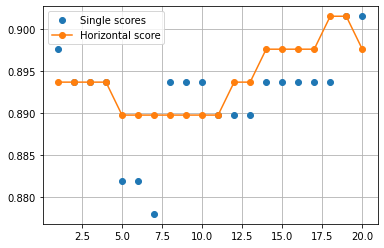

In [99]:
horizontal_validate(model, 80, 60, threshold =0.45)